In [ ]:
import sys,os,glob,copy
import numpy as np
from numpy.linalg import norm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d
import matplotlib as mpl
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
import glob
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps['RdYlBu']


pd.set_option('display.max_rows', 200)

In [2]:
inputFiles = ['./matcpp2BB1j_atlas/Events/run_01/cdfo_500_450.0_tau_1e-02_djrs.dat',
              './pp2BB1j_atlas_small_qcut/Events/run_01/cdfo_500_450.0_tau_1e-02_djrs.dat']

### Get Qcut

In [3]:
qcuts = []
for inputFile in inputFiles:
    dirname = os.path.dirname(inputFile)
    filename = os.path.basename(inputFile).replace('_djrs.dat','_merged_xsecs.txt')
    matchFile = os.path.join(dirname,filename)
    with open(matchFile,'r') as f:
        qcutNew = eval(f.readlines()[1].split()[0])
    qcuts.append(qcutNew)
    print('qcut = %1.2f' %qcutNew)

if len(set(qcuts)) != 1:
    print('!!!Using files with distinct qcut values!!!')


qcut = 375.00
qcut = 50.00
!!!Using files with distinct qcut values!!!


### Get histograms

In [4]:
histsList = []

for inputFile in inputFiles:
    histsList.append({})
    histsDict = histsList[-1]
    with open(inputFile,'r') as f:
        data = f.read()
    data = data.split('<histogram>')[1:]
    for block in data:
        block = block.split('<\\histogram>')[0]
        block = block.split('\n')
        header = block[0]
        pts = np.array([[eval(x) for x in l.split() if x] for l in block[1:] if l.strip()])
        label = header.split('|')
        label = (label[0].split()[1].replace('"',''),label[-1].replace('"',''))
        if not label[0] in histsDict:
            histsDict[label[0]] = {}
        if not label[1] in histsDict[label[0]]:
            histsDict[label[0]].update({label[1] : pts})
        else:
            histsDict[label[0]][label[1]][:,-2] += pts[:,-2]
            histsDict[label[0]][label[1]][:,-1] += pts[:,-1]

In [5]:
### Remove plots for DJR larger than nJetmax:
for histsDict in histsList:
    nJetmax = max([eval(x.split('@')[1]) for x in list(histsDict.values())[0].keys()])
    for label in list(histsDict.keys()):
        if eval(label.strip()[-1]) > nJetmax:
            histsDict.pop(label)

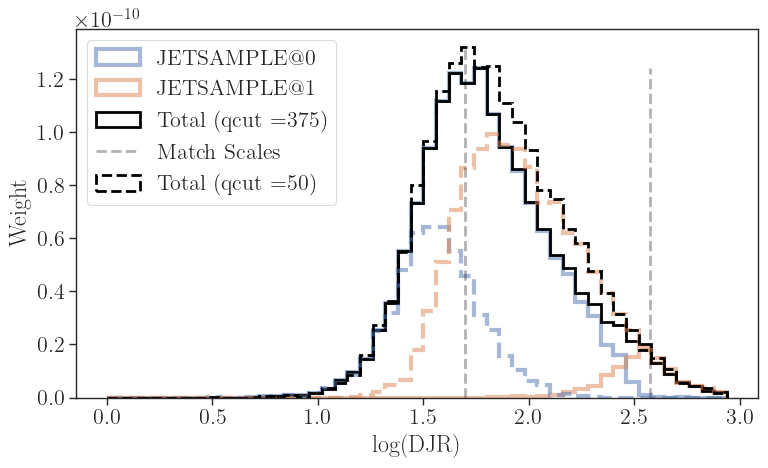

In [6]:
nplots = len(histsList[0])
if nplots > 1:
    fig,axarr = plt.subplots(figsize=(16,5*int(nplots/2.)),nrows=int(nplots/2.),ncols=2,
                         sharey=True)
else:
    fig,axarr = plt.subplots(figsize=(8,5),nrows=1,ncols=1,
                         sharey=True)
    axarr = np.array([axarr])


nbins = 2 # Controls how many bins are merged together (from the original histogram)
linestyles = ['solid','dashed','dotted']
colors = sns.color_palette('deep')
for ihist,histsDict in enumerate(histsList):
    for iplot,label in enumerate(histsDict):
        ax = axarr.ravel()[iplot]
        total = None
        isample = 0
        for sample,pts in histsDict[label].items():
            if ihist == 0:
                label = sample
                labelMatch = 'Match Scales'
            else:
                label = None
                labelMatch = None
            binc,bins,_ = ax.hist(pts[:,0],weights=pts[:,-2],
                    label=label,bins=pts[:,0][::nbins],
                    histtype='step',linewidth=3,alpha=0.5,linestyle=linestyles[ihist],color=colors[isample])
            isample += 1
            if total is None:
                total = np.zeros(len(bins)-1)
            total += binc    
        ax.hist(bins[:-1],weights=total,bins=bins,label='Total (qcut =%1.0f)' %qcuts[ihist],histtype='step',color='black',
                linewidth=2,linestyle=linestyles[ihist])    
        ax.vlines(x=np.log10(qcuts[ihist]),ymin=total.min(),ymax=total.max(),linestyle='--',alpha=0.3,
                color='black',linewidth=2,label=labelMatch)
        
        ax.set_xlabel('log(DJR)')
        ax.set_ylabel('Weight')
        # ax.set_yscale('log')
        ax.set_title(label)
        if iplot == 0:
            ax.legend(loc='upper left',framealpha=0.7)
plt.tight_layout()
# plt.savefig(inputFile.replace('.dat','.png'))
plt.show()

In [10]:
np.log10(375)

2.574031267727719

In [19]:
np.log10((500/4.)*(3./2.))

2.2730012720637376